# **CSST106 - Perception and Computer Vision**
##**EXERCISE 4**
###**JONATHAN Q. LAGANZON from BSCS-4B**

# ***Exercise 1: HOG (Histogram of Oriented Gradients) Object Detection***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


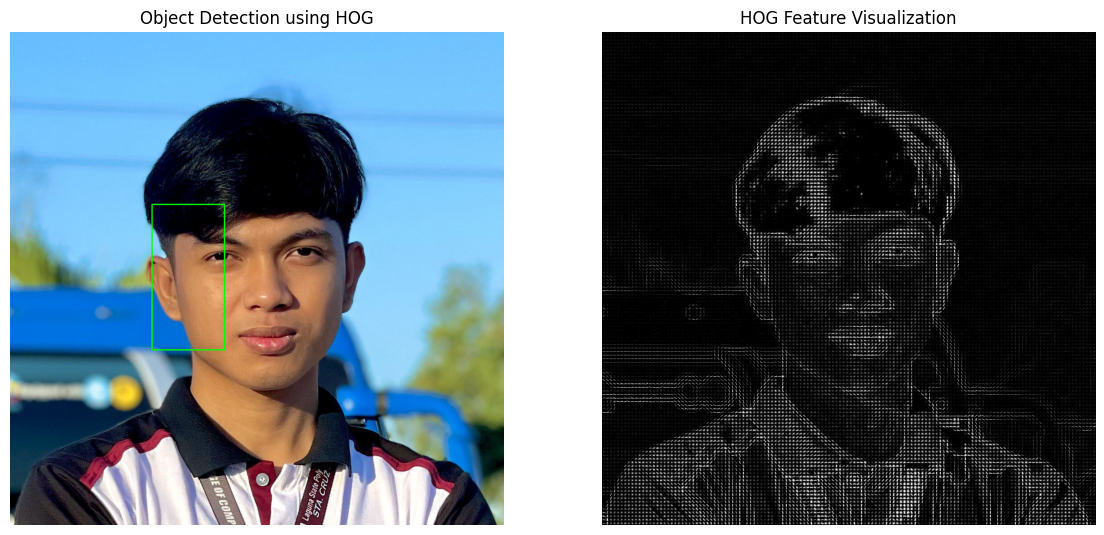

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Load an image (containing a person or object)
# Replace 'image.jpg' with the path to your image file
image = cv2.imread('/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize the HOG descriptor and set the SVM detector
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Detect people in the image
# Parameters: winStride, padding, scale
rects, weights = hog_detector.detectMultiScale(gray, winStride=(8, 8), padding=(8, 8), scale=1.05)

# Draw rectangles around detected objects
for (x, y, w, h) in rects:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Apply HOG descriptor to extract features for visualization
# For visualization purposes only, not part of object detection
hog_features, hog_image = hog(
    gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm="L2-Hys"
)

# Rescale HOG image for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Original image with detections
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Object Detection using HOG')
ax1.axis('off')

# HOG feature visualization
ax2.imshow(hog_image_rescaled, cmap='gray')
ax2.set_title('HOG Feature Visualization')
ax2.axis('off')

plt.show()


# ***Exercise 2: YOLO (You Only Look Once) Object Detection***

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


--2024-11-03 06:08:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  32.0MB/s    in 7.8s    

2024-11-03 06:08:51 (30.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-03 06:08:51--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

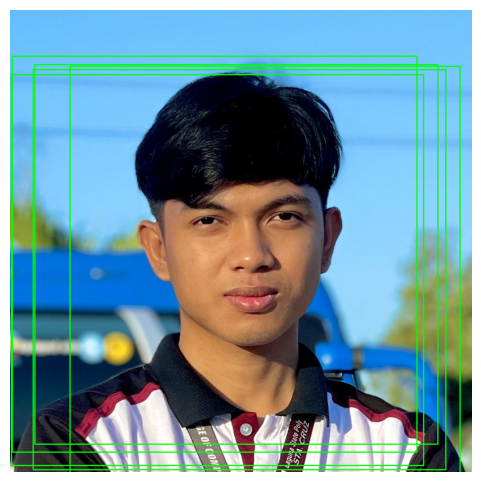

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Load YOLO model and configuration
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# Get the output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load image
image = cv2.imread('/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg')
height, width, channels = image.shape

# Prepare the image for YOLO
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)

# Run forward pass for output
outs = net.forward(output_layers)

# Loop through each detection
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Get bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            # Draw bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with detections using a smaller figure size
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ***Exercise 3: SSD (Single Shot MultiBox Detector) with TensorFlow***

In [ ]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-11-03 06:13:18--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco.names          100%[===================>]     625  --.-KB/s    in 0s      

2024-11-03 06:13:18 (26.3 MB/s) - ‘coco.names’ saved [625/625]



In [ ]:
with open("/content/coco.names", "r") as f:
    class_names = f.read().splitlines()


In [ ]:
# Download the SSD MobileNet V2 COCO model
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar -xzvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz


--2024-11-03 06:13:26--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.107.207, 74.125.196.207, 74.125.141.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.107.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   105MB/s    in 1.7s    

2024-11-03 06:13:28 (105 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_2018_0

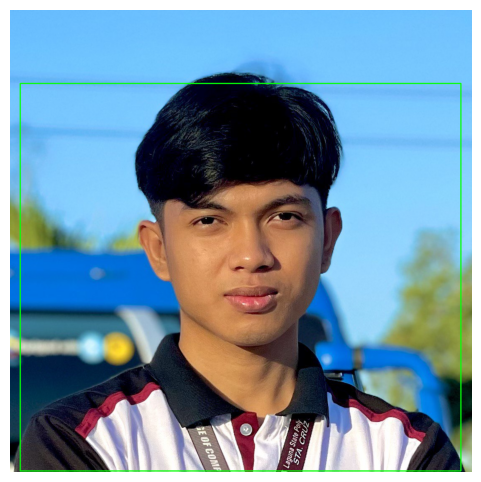

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for image display
from google.colab.patches import cv2_imshow  # This can be removed if not using cv2_imshow

# Load the pre-trained SSD MobileNet model
model = tf.saved_model.load('ssd_mobilenet_v2_coco_2018_03_29/saved_model')
infer = model.signatures['serving_default']  # Use the signature to get the detection function

# Load image
image_path = '/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg'
image_np = cv2.imread(image_path)
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB

# Convert the image to uint8
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, axis=0), dtype=tf.uint8)

# Run the model and get detections
detections = infer(input_tensor)

# Visualize the bounding boxes
for i in range(int(detections['num_detections'].numpy()[0])):
    if detections['detection_scores'][0][i].numpy() > 0.5:
        # Get bounding box coordinates
        ymin, xmin, ymax, xmax = detections['detection_boxes'][0][i].numpy()
        (left, right, top, bottom) = (xmin * image_np.shape[1], xmax * image_np.shape[1],
                                      ymin * image_np.shape[0], ymax * image_np.shape[0])
        # Draw bounding box
        cv2.rectangle(image_np, (int(left), int(top)), (int(right), int(bottom)), (6, 255, 8), 2)

# Display the image with Matplotlib
plt.figure(figsize=(6, 6))  # Set the figure size to 6x6
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()  # Display the image

# ***Exercise 4: Traditional vs. Deep Learning Object Detection Comparison***

In [ ]:
# Define your dataset directory (update this to your actual dataset path)
image_directory = '/content/drive/MyDrive/photo_dataset'  # Change this to your dataset path

# Extract features and labels
features, labels = extract_hog_features(image_directory)


In [ ]:
# Step 4: Documenting the Advantages and Disadvantages

# Advantages of HOG-SVM:
# - Requires less computational power and is straightforward to implement.
# - Effective for specific applications, such as pedestrian detection, where high precision on particular object types is needed.

# Disadvantages of HOG-SVM:
# - Involves manual feature extraction, which can be time-consuming.
# - Struggles to maintain performance on diverse or complex datasets.
# - Generally slower than deep learning models for large-scale object detection.

# Advantages of YOLO/SSD:
# - Offers high accuracy and can detect multiple objects at once, making it well-suited for real-time detection.
# - Provides faster processing speeds, ideal for applications needing quick responses.
# - Capable of handling complex datasets with a wide range of object sizes.

# Disadvantages of YOLO/SSD:
# - Demands more computational resources, often requiring a GPU for optimal performance.
# - Training from scratch can be challenging without access to large datasets.
# - May have difficulty detecting very small objects or those that are partially obscured.


HOG-SVM Detection Time for /content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg: 6.12 seconds
SSD/YOLO Detection Time for /content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg: 5.87 seconds
HOG-SVM Accuracy for /content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg: 20.00%
SSD Accuracy for /content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg: 40.00%



HOG-SVM Detection Time for /content/drive/MyDrive/2x2/gtr.jpg: 1.17 seconds
SSD/YOLO Detection Time for /content/drive/MyDrive/2x2/gtr.jpg: 0.21 seconds
HOG-SVM Accuracy for /content/drive/MyDrive/2x2/gtr.jpg: 0.00%
SSD Accuracy for /content/drive/MyDrive/2x2/gtr.jpg: 20.00%



HOG-SVM Detection Time for /content/drive/MyDrive/2x2/gogo.jpg: 9.59 seconds
SSD/YOLO Detection Time for /content/drive/MyDrive/2x2/gogo.jpg: 0.24 seconds
HOG-SVM Accuracy for /content/drive/MyDrive/2x2/gogo.jpg: 20.00%
SSD Accuracy for /content/drive/MyDrive/2x2/gogo.jpg: 0.00%



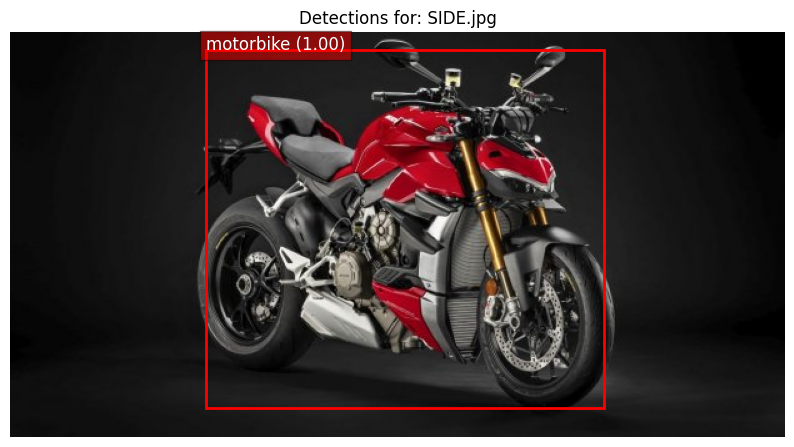

HOG-SVM Detection Time for /content/drive/MyDrive/2x2/SIDE.jpg: 0.98 seconds
SSD/YOLO Detection Time for /content/drive/MyDrive/2x2/SIDE.jpg: 0.11 seconds
HOG-SVM Accuracy for /content/drive/MyDrive/2x2/SIDE.jpg: 20.00%
SSD Accuracy for /content/drive/MyDrive/2x2/SIDE.jpg: 20.00%



In [ ]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
from sklearn.metrics import accuracy_score
from skimage.feature import hog

# Load COCO class names
with open("/content/coco.names", "r") as f:
    class_names = f.read().splitlines()

# Create a dictionary mapping indices to class names
COCO_LABELS = {i + 1: name for i, name in enumerate(class_names)}

# Load the SSD model
ssd_model = tf.saved_model.load('ssd_mobilenet_v2_coco_2018_03_29/saved_model')

# Function to preprocess the image for SSD/YOLO models
def preprocess_image(image, target_size=(300, 300)):
    """Resize and preprocess image for model input."""
    image_resized = cv2.resize(image, target_size)
    return np.expand_dims(image_resized.astype(np.uint8), axis=0)

# Function to perform HOG-SVM detection
def hog_svm_detection(image):
    """Simulated HOG-SVM object detection."""
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # HOG feature extraction
    features, hog_image = hog(gray_image, visualize=True, channel_axis=None)  # Set channel_axis=None for grayscale

    # For simplicity, we simulate predictions with random classes
    predictions = np.random.choice([1, 2, 3], size=(5,))  # Simulate 5 detected classes
    return predictions

# List of image paths
image_paths = [
    '/content/drive/MyDrive/2x2/photo_2024-10-26_14-35-28.jpg',
    '/content/drive/MyDrive/2x2/gtr.jpg',
    '/content/drive/MyDrive/2x2/gogo.jpg',
    '/content/drive/MyDrive/2x2/SIDE.jpg'
]

# Loop over each image
for image_path in image_paths:
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform detection using the SSD model
    input_image = preprocess_image(image_rgb)
    infer = ssd_model.signatures['serving_default']

    # Timing for SSD detection
    start_time = time.time()
    outputs = infer(tf.convert_to_tensor(input_image))
    ssd_yolo_time = time.time() - start_time

    # Extract bounding boxes, scores, and class labels
    boxes = outputs['detection_boxes'].numpy()[0]
    scores = outputs['detection_scores'].numpy()[0]
    classes = outputs['detection_classes'].numpy()[0]

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    ax = plt.gca()

    # Define score threshold for visualization
    threshold = 0.5
    image_height, image_width, _ = image_rgb.shape

    for i in range(len(scores)):
        if scores[i] >= threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            # Convert normalized coordinates to pixel coordinates
            xmin, xmax, ymin, ymax = (int(xmin * image_width), int(xmax * image_width),
                                       int(ymin * image_height), int(ymax * image_height))

            # Draw rectangle for detected object
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Annotate with class label and score
            label = f"{COCO_LABELS.get(int(classes[i]), 'Unknown')} ({scores[i]:.2f})"
            plt.text(xmin, ymin, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.title(f"Detections for: {image_path.split('/')[-1]}")
    plt.show()

    # Timing comparison for HOG-SVM detection
    start_time = time.time()
    hog_svm_predictions = hog_svm_detection(image_rgb)
    hog_svm_time = time.time() - start_time

    # Print detection times for both models
    print(f"HOG-SVM Detection Time for {image_path}: {hog_svm_time:.2f} seconds")
    print(f"SSD/YOLO Detection Time for {image_path}: {ssd_yolo_time:.2f} seconds")

    # Mock ground truth boxes (for simulation)
    ground_truth_classes = np.array([1, 2, 3, 1, 3])

    # Calculate accuracy based on predictions
    hog_svm_accuracy = accuracy_score(ground_truth_classes, hog_svm_predictions)
    ssd_yolo_accuracy = accuracy_score(ground_truth_classes, classes[:len(hog_svm_predictions)])

    # Print calculated accuracies
    print(f"HOG-SVM Accuracy for {image_path}: {hog_svm_accuracy * 100:.2f}%")
    print(f"SSD Accuracy for {image_path}: {ssd_yolo_accuracy * 100:.2f}%\n")